
## Imports

In [1]:
import numpy as np
import librosa as lr
import madmom as mm
import librosa.display as display
import pretty_midi as pm
import matplotlib.pyplot as plt
import copy

from keras.models import Model
from keras.layers import Input, Dense, Input, Conv2D, Flatten
from keras.layers import GaussianDropout, GaussianNoise, Reshape
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Constants

In [2]:
DATAPOINT = "../datasets/maps/CH/" + \
            "MAPS_ISOL_CH0.1_F_SptkBGAm.wav"
MIDI_DATAPOINT = "../datasets/maps/CH/" + \
        "MAPS_ISOL_CH0.1_F_SptkBGAm.mid"
WINDOW_SIZE = 11

## Helpers

In [3]:
def generate_midi_onsets(midi, pad_space):
    midi_onsets = copy.deepcopy(midi)
    
    for note in midi_onsets.instruments[0].notes:
        temp = note.start
        note.start = temp - pad_space
        note.end = temp + pad_space
    
    return midi_onsets


def generate_midi_offsets(midi, pad_space):
    midi_offsets = copy.deepcopy(midi)
    
    for note in midi_offsets.instruments[0].notes:
        temp = note.end
        note.start = note.end - pad_space
        note.end = temp + pad_space
    
    return midi_offsets

## Wrangle Datapoint

In [4]:
log_spect = mm.audio.spectrogram.LogarithmicFilteredSpectrogram(
    DATAPOINT,
    num_bands=24, # 48
    num_channels=1, 
    sr=44100,
    unique_filters=True,
    norm_filters=True,
    frame_size=4096, # 4096
    fft_size=4096,
    fps=50,
    fmin=30.0,
    fmax=10000.0, # 2325 for 144 bins. 8000 for 229 bins
    fref=440.0,
    circular_shift=False,
    hop_size=441.0 * 2) # 441.0

In [5]:
log_spect.shape

(1093, 144)

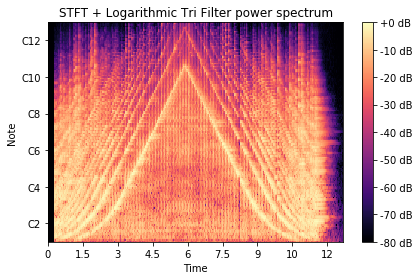

In [6]:
lr.display.specshow(
    lr.amplitude_to_db(log_spect, ref=np.max).T, 
    sr=44100,
    x_axis='time',
    y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT + Logarithmic Tri Filter power spectrum')
plt.tight_layout()

#### Ground Truth:

In [7]:
times = lr.frames_to_time(
    np.arange(log_spect.shape[0]),
    sr=44100,
    hop_length=441.0 * 2)
midi = pm.PrettyMIDI(MIDI_DATAPOINT)

In [8]:
offsets_midi = generate_midi_offsets(midi, times[1])
onsets_midi = generate_midi_onsets(midi, times[1])

In [9]:
yFroms = midi.get_piano_roll(fs=44100, times=times)[21:108+1].T
yFroms[yFroms > 0] = 0.35

midi_onsets = generate_midi_onsets(midi, times[1])
yOns = midi_onsets.get_piano_roll(fs=44100, times=times)[21:108+1].T
yOns[yOns > 0] = 0.5

midi_offsets = generate_midi_offsets(midi, times[1])
yOffs = midi_offsets.get_piano_roll(fs=44100, times=times)[21:108+1].T
yOffs[yOffs > 0] = 0.2

In [10]:
print yFroms.shape
print yOns.shape
print yOffs.shape

(1093, 88)
(1093, 88)
(1093, 88)


#### Visualize:

In [11]:
mask = (yOns == 0)
combined = np.copy(yOns)
combined[mask] = yOffs[mask]

mask = (combined == 0)
combined = np.copy(combined)
combined[mask] = yFroms[mask]
print combined.shape

(1093, 88)


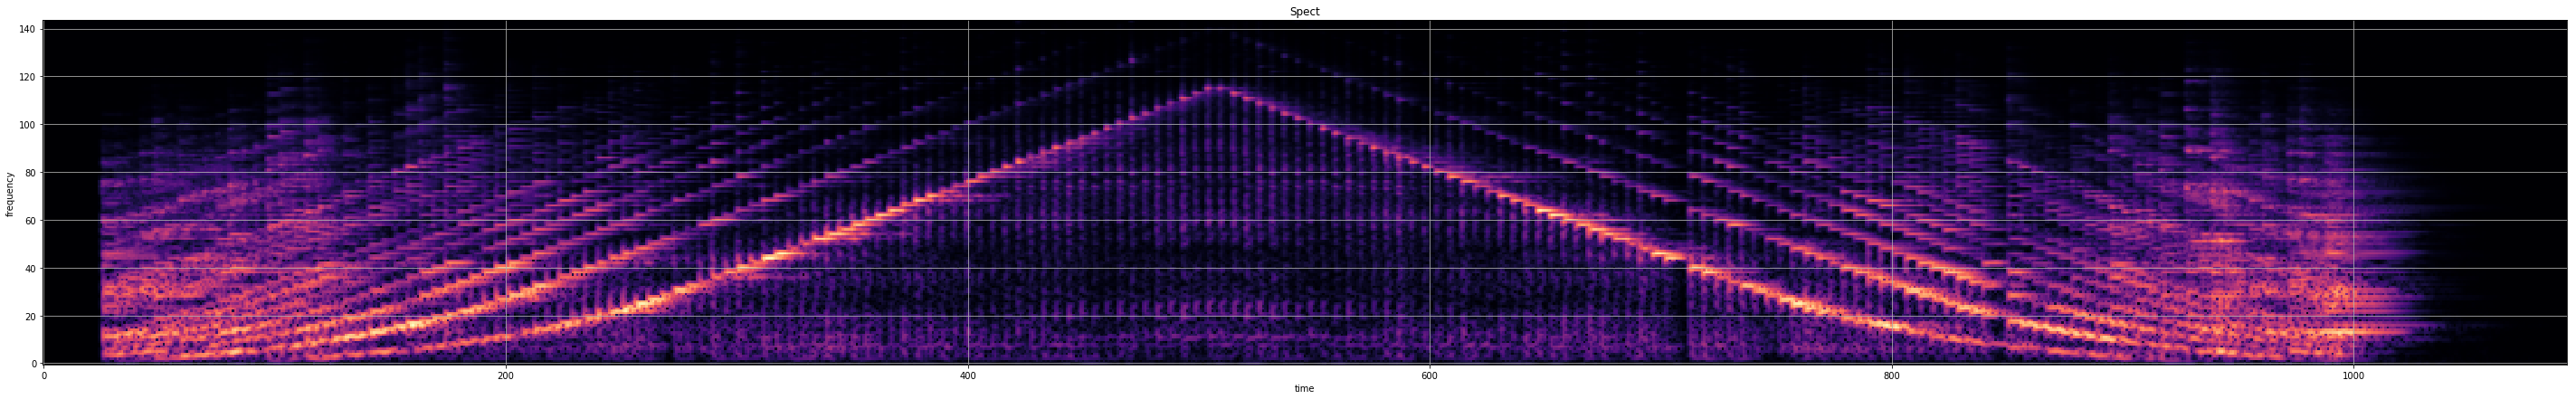

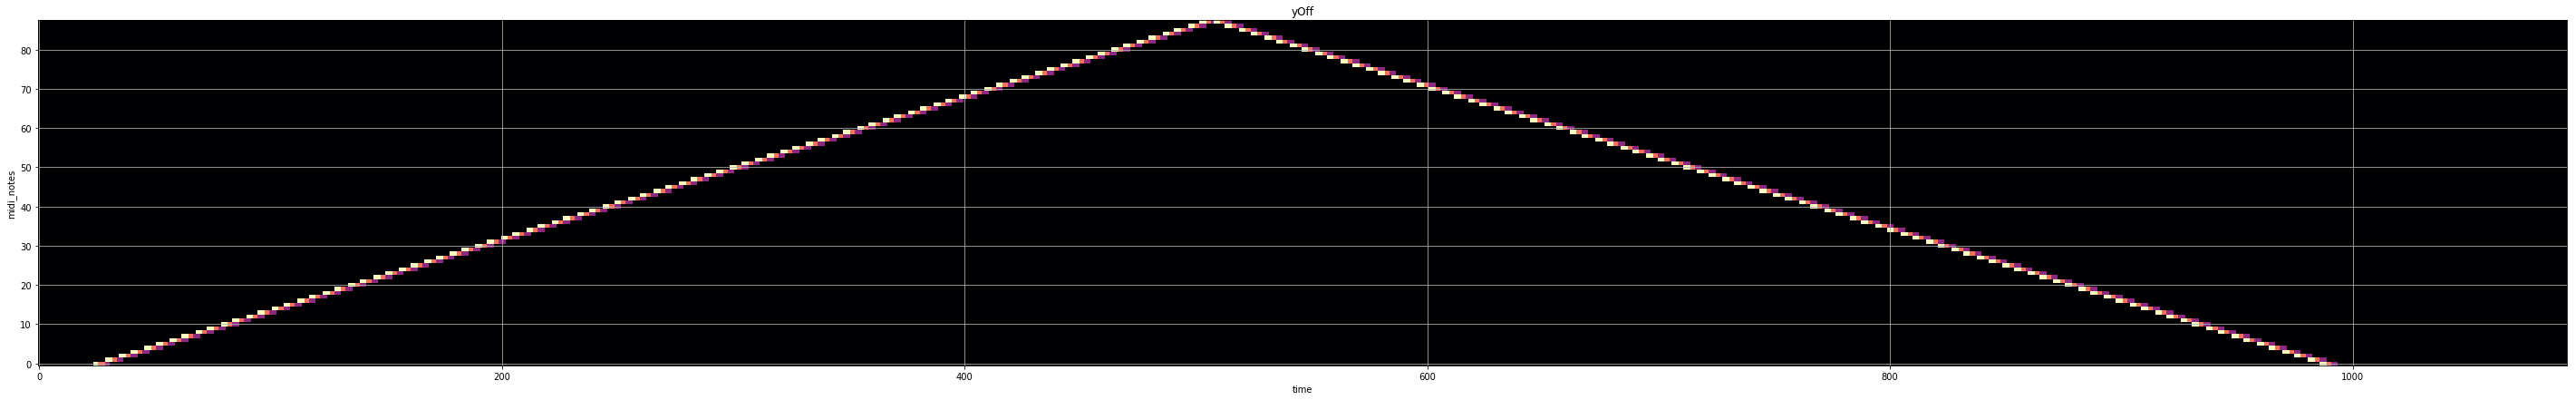

In [12]:
length = 50

fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(log_spect.T ,aspect='auto', cmap='magma')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('frequency')
plt.title("Spect")
plt.show()

fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(combined.T ,aspect='auto', cmap='magma')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.title("yOff")
plt.show()

In [13]:
# Reset
yFroms[yFroms > 0] = 1
yOns[yOns > 0] = 1
yOffs[yOffs > 0] = 1

## Preprocess Datapoint

In [14]:
min_db = np.min(log_spect)
min_db
log_spect = np.pad(
    log_spect, 
    ((WINDOW_SIZE//2, WINDOW_SIZE//2), (0,0)),
    'constant',
    constant_values=min_db)

In [15]:
log_spect.shape

(1103, 144)

In [16]:
windows = []

for i in range(log_spect.shape[0] - WINDOW_SIZE + 1):
    w = log_spect[i:i+WINDOW_SIZE,:]
    windows.append(w)

windowed_datapoints = np.array(windows)

In [17]:
windowed_datapoints.shape

(1093, 11, 144)

## Compile Model

In [32]:
# # LogFilt dims
# inputs = Input(shape=(11, 144), name='main_input')
# reshape = Reshape((11, 144, 1))(inputs)

# HCQT dims
inputs = Input(shape=(5, 360, 6), name='main_input')
reshape = Reshape((5, 360, 6))(inputs)

c1 = Conv2D(30, (3, 3), activation='elu')(reshape)
gd1 = GaussianDropout(0.1)(c1)
gn1 = GaussianNoise(0.1)(gd1)

c2 = Conv2D(30, (1, 35), activation='elu')(gn1)
gd2 = GaussianDropout(0.1)(c2)
gn2 = GaussianNoise(0.1)(gd2)

c3 = Conv2D(30, (3, 3), activation='elu')(gn2)
gd3 = GaussianDropout(0.1)(c3)
gn3 = GaussianNoise(0.1)(gd3)

# y-on
c4 = Conv2D(10, (3, 3), activation='elu')(gn3)
gd4 = GaussianDropout(0.5)(c4)
gn4 = GaussianNoise(0.1)(gd4)
f1 = Flatten()(gn4)
yOn = Dense(88, activation='sigmoid', name='yOn')(f1)

# y-frm
c5 = Conv2D(10, (3, 3), activation='elu')(gn3)
gd5 = GaussianDropout(0.5)(c5)
gn5 = GaussianNoise(0.1)(gd5)
f2 = Flatten()(gn5)
yFrom = Dense(88, activation='sigmoid', name='yFrom')(f2)

# y-off
c6 = Conv2D(10, (3, 3), activation='elu')(gn3)
gd6 = GaussianDropout(0.5)(c6)
gn6 = GaussianNoise(0.1)(gd6)
f3 = Flatten()(gn6)
yOff = Dense(88, activation='sigmoid', name='yOff')(f3)

adsr_net = Model(inputs=inputs, outputs=[yOn, yFrom, yOff])

ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_45/convolution' (op: 'Conv2D') with input shapes: [?,1,322,30], [3,3,30,10].

In [30]:
adsr_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 11, 360, 6)   0                                            
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 11, 360, 6)   0           main_input[0][0]                 
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 9, 358, 30)   1650        reshape_9[0][0]                  
__________________________________________________________________________________________________
gaussian_dropout_28 (GaussianDr (None, 9, 358, 30)   0           conv2d_33[0][0]                  
__________________________________________________________________________________________________
gaussian_n

In [50]:
adsr_net.compile(
    loss={'yOn':'binary_crossentropy', 'yFrom':'binary_crossentropy', 'yOff':'binary_crossentropy'},
    optimizer=SGD(lr=0.05, momentum=0.9, nesterov=True),
    metrics=['accuracy', 'mse', 'mae'])

## Train

In [ ]:
print windowed_datapoints.shape
print yOns.shape
print yFroms.shape
print yOffs.shape

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

In [ ]:
adsr_net.fit(windowed_datapoints,
            {"yOn": yOns, "yFrom": yFroms, "yOff": yOffs},
            epochs=1, 
            batch_size=64, 
            verbose=1,
            callbacks=[reduce_lr],
            validation_split=0.18)

## Evaluate

In [ ]:
predictions = adsr_net.predict(windowed_datapoints, verbose=1)

In [ ]:
len(predictions)